# Adversarial Attacks

## Einleitung

Während Forschung und Entwicklung oft auf die Verbesserung von Genauigkeit, Geschwindigkeit und Effizienz abzielen, bleibt ein ebenso wichtiger Aspekt häufig unbeachtet: die Sicherheit und Robustheit solcher Modelle gegenüber gezielten Angriffen.

Dieses Notebook soll ein Bewusstsein für die Sicherheitsrisiken schaffen, die mit Machine-Learning-Modellen verbunden sind. Es untersucht die Schwachstellen eines vortrainierten Bildklassifikationsmodells mithilfe eines adversarial Attacks. Konkret wird die **Fast Gradient Sign Method (FGSM)** [1] implementiert und evaluiert, ein einfacher und effizienter Ansatz zur Generierung adversarialer Beispiele. Ziel ist es, die Robustheit des Modells gegenüber solchen Angriffen zu bewerten und potenzielle Maßnahmen zur Verbesserung der Sicherheit aufzuzeigen. 

---

<small>
### Referenzen

[1] Ian J. Goodfellow et al., "Explaining and Harnessing Adversarial Examples", [https://arxiv.org/abs/1412.6572](https://arxiv.org/abs/1412.6572)  
</small>


## Modell

Adversarielle Angriffe nutzen gezielte, minimale Perturbationen in Eingabedaten, die für das menschliche Auge meist unsichtbar sind, jedoch maschinelle Lernmodelle mit hoher Wahrscheinlichkeit zu Fehlklassifikationen verleiten können. In diesem Kontext trainieren wir ein vortrainiertes ResNet50-Bildklassifikationsmodell auf dem MNIST-Datensatz und evaluieren dessen Leistung, um ein besseres Verständnis für die Robustheit solcher Modelle zu gewinnen.


#### Bibliotheken importieren

In [6]:
# Importieren der benötigten Bibliotheken
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from fgsm_attack import test_fgsm
from utils import plot_and_save_adversarial_examples, plot_accuracy_vs_epsilon
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import os


#### Daten laden und vorverarbeiten

In [7]:
# MNIST-Datensatz laden
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Daten vorverarbeiten: Reshape, Normalisieren und Größe ändern
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)).astype('float32') / 255.0
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)).astype('float32') / 255.0

# Bilder auf 32x32 vergrößern für ResNet50
x_train = tf.image.resize(x_train, (32, 32))
x_test = tf.image.resize(x_test, (32, 32))

# Graustufenbilder in 3-Kanal-RGB-Bilder konvertieren
x_train = np.repeat(x_train, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

# Labels in One-Hot-Encoding umwandeln
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


#### Modell erstellen oder laden

In [8]:
# Dateipfad für das Modell
MODEL_PATH = "mnist_resnet50_model.h5"

if not os.path.exists(MODEL_PATH):
    print("Modell nicht gefunden. Starte Training...")

    # ResNet50-Modell aufbauen
    model = Sequential([
        ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape=(32, 32, 3)),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.layers[0].trainable = False  # ResNet50-Schichten einfrieren

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Datenaugmentation
    train_generator = ImageDataGenerator(
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest'
    )
    train_iterator = train_generator.flow(x_train, y_train, batch_size=512, shuffle=True)
    val_iterator = ImageDataGenerator().flow(x_test, y_test, batch_size=512, shuffle=False)

    # Modell trainieren
    model.fit(train_iterator, validation_data=val_iterator, epochs=5)

    # Modell speichern
    model.save(MODEL_PATH)
else:
    print("Trainiertes Modell gefunden. Lade gespeichertes Modell...")
    model = tf.keras.models.load_model(MODEL_PATH)


Modell nicht gefunden. Starte Training...


C:\Users\yassi\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.4216 - loss: 1.8197

C:\Users\yassi\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


118/118 ━━━━━━━━━━━━━━━━━━━━ 113s 905ms/step - accuracy: 0.4228 - loss: 1.8160 - val_accuracy: 0.7902 - val_loss: 0.7259
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 93s 783ms/step - accuracy: 0.7172 - loss: 0.9115 - val_accuracy: 0.8436 - val_loss: 0.5403
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 87s 736ms/step - accuracy: 0.7608 - loss: 0.7570 - val_accuracy: 0.8647 - val_loss: 0.4558
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 97s 821ms/step - accuracy: 0.7861 - loss: 0.6749 - val_accuracy: 0.8694 - val_loss: 0.4261
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 93s 789ms/step - accuracy: 0.8075 - loss: 0.6077 - val_accuracy: 0.8652 - val_loss: 0.4193


#### Modell evaluieren

In [9]:
# Modell evaluieren
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("\n--- Testergebnisse ---")
print(f"Testgenauigkeit: {test_accuracy * 100:.2f}%")
print(f"Testverlust: {test_loss:.4f}")


313/313 - 21s - 67ms/step - accuracy: 0.8652 - loss: 0.4193

--- Testergebnisse ---
Testgenauigkeit: 86.52%
Testverlust: 0.4193


## Fast Gradient Sign Method (FGSM)

Mit einer Testgenauigkeit von 86.52 % bildet dieses Modell, optimiert durch Transfer Learning, die Grundlage für die Implementierung der **Fast Gradient Sign Method (FGSM)** [1]. FGSM ist ein effizienter White-Box-Angriff, der Gradienteninformationen nutzt, um gezielte Störungen zu erzeugen und die Robustheit des Modells zu testen. Diese Methode ist ressourcenschonend und eignet sich ideal zur Analyse von Standardmodellen.

---

<small>
### Referenzen

[1] Ian J. Goodfellow et al., "Explaining and Harnessing Adversarial Examples", [https://arxiv.org/abs/1412.6572](https://arxiv.org/abs/1412.6572)  
</small>


#### FGSM-Angriffe testen

Die Funktion `fgsm_attack` erzeugt adversarielle Beispiele, indem sie die ursprünglichen Eingaben `x` in Richtung des Gradienten der Verlustfunktion $ J(\theta, x, y) $ verändert. Der Gradientenvektor $ \nabla_x J(\theta, x, y) $ gibt an, wie stark eine kleine Änderung in `x` den Verlust beeinflusst.

Die Berechnung der adversariellen Eingabe erfolgt mit der folgenden Formel:

$$
x_{\text{perturbed}} = x + \epsilon \cdot \text{sign}(\nabla_x J(\theta, x, y))
$$

Hierbei ist:
- **`x`**: Das ursprüngliche Eingabebild.
- **`ϵ`**: Die Stärkeskalierung der Störung.
- **`sign(·)`**: Die Vorzeichendfunktion, die die Richtung der größten Verlustzunahme angibt.

Schließlich wird $ x_{\text{perturbed}} $ auf den Bereich $ [0, 1] $ begrenzt, um gültige Eingaben für das Modell zu gewährleisten.



In [11]:
# FGSM-Angriff implementieren
from fgsm_attack import fgsm_attack

# Beispielaufruf
epsilons = [0, 0.05, 0.1, 0.2, 0.3]
results = test_fgsm(model, x_test[:100], y_test[:100], epsilons)


Teste FGSM mit epsilon = 0
Epsilon: 0	Genauigkeit: 87 / 100 = 0.8700
Teste FGSM mit epsilon = 0.05
Epsilon: 0.05	Genauigkeit: 43 / 100 = 0.4300
Teste FGSM mit epsilon = 0.1
Epsilon: 0.1	Genauigkeit: 24 / 100 = 0.2400
Teste FGSM mit epsilon = 0.2
Epsilon: 0.2	Genauigkeit: 2 / 100 = 0.0200
Teste FGSM mit epsilon = 0.3
Epsilon: 0.3	Genauigkeit: 2 / 100 = 0.0200
Ergebnisse wurden in fgsm_results.json gespeichert.


#### Ergebnisse visualisieren

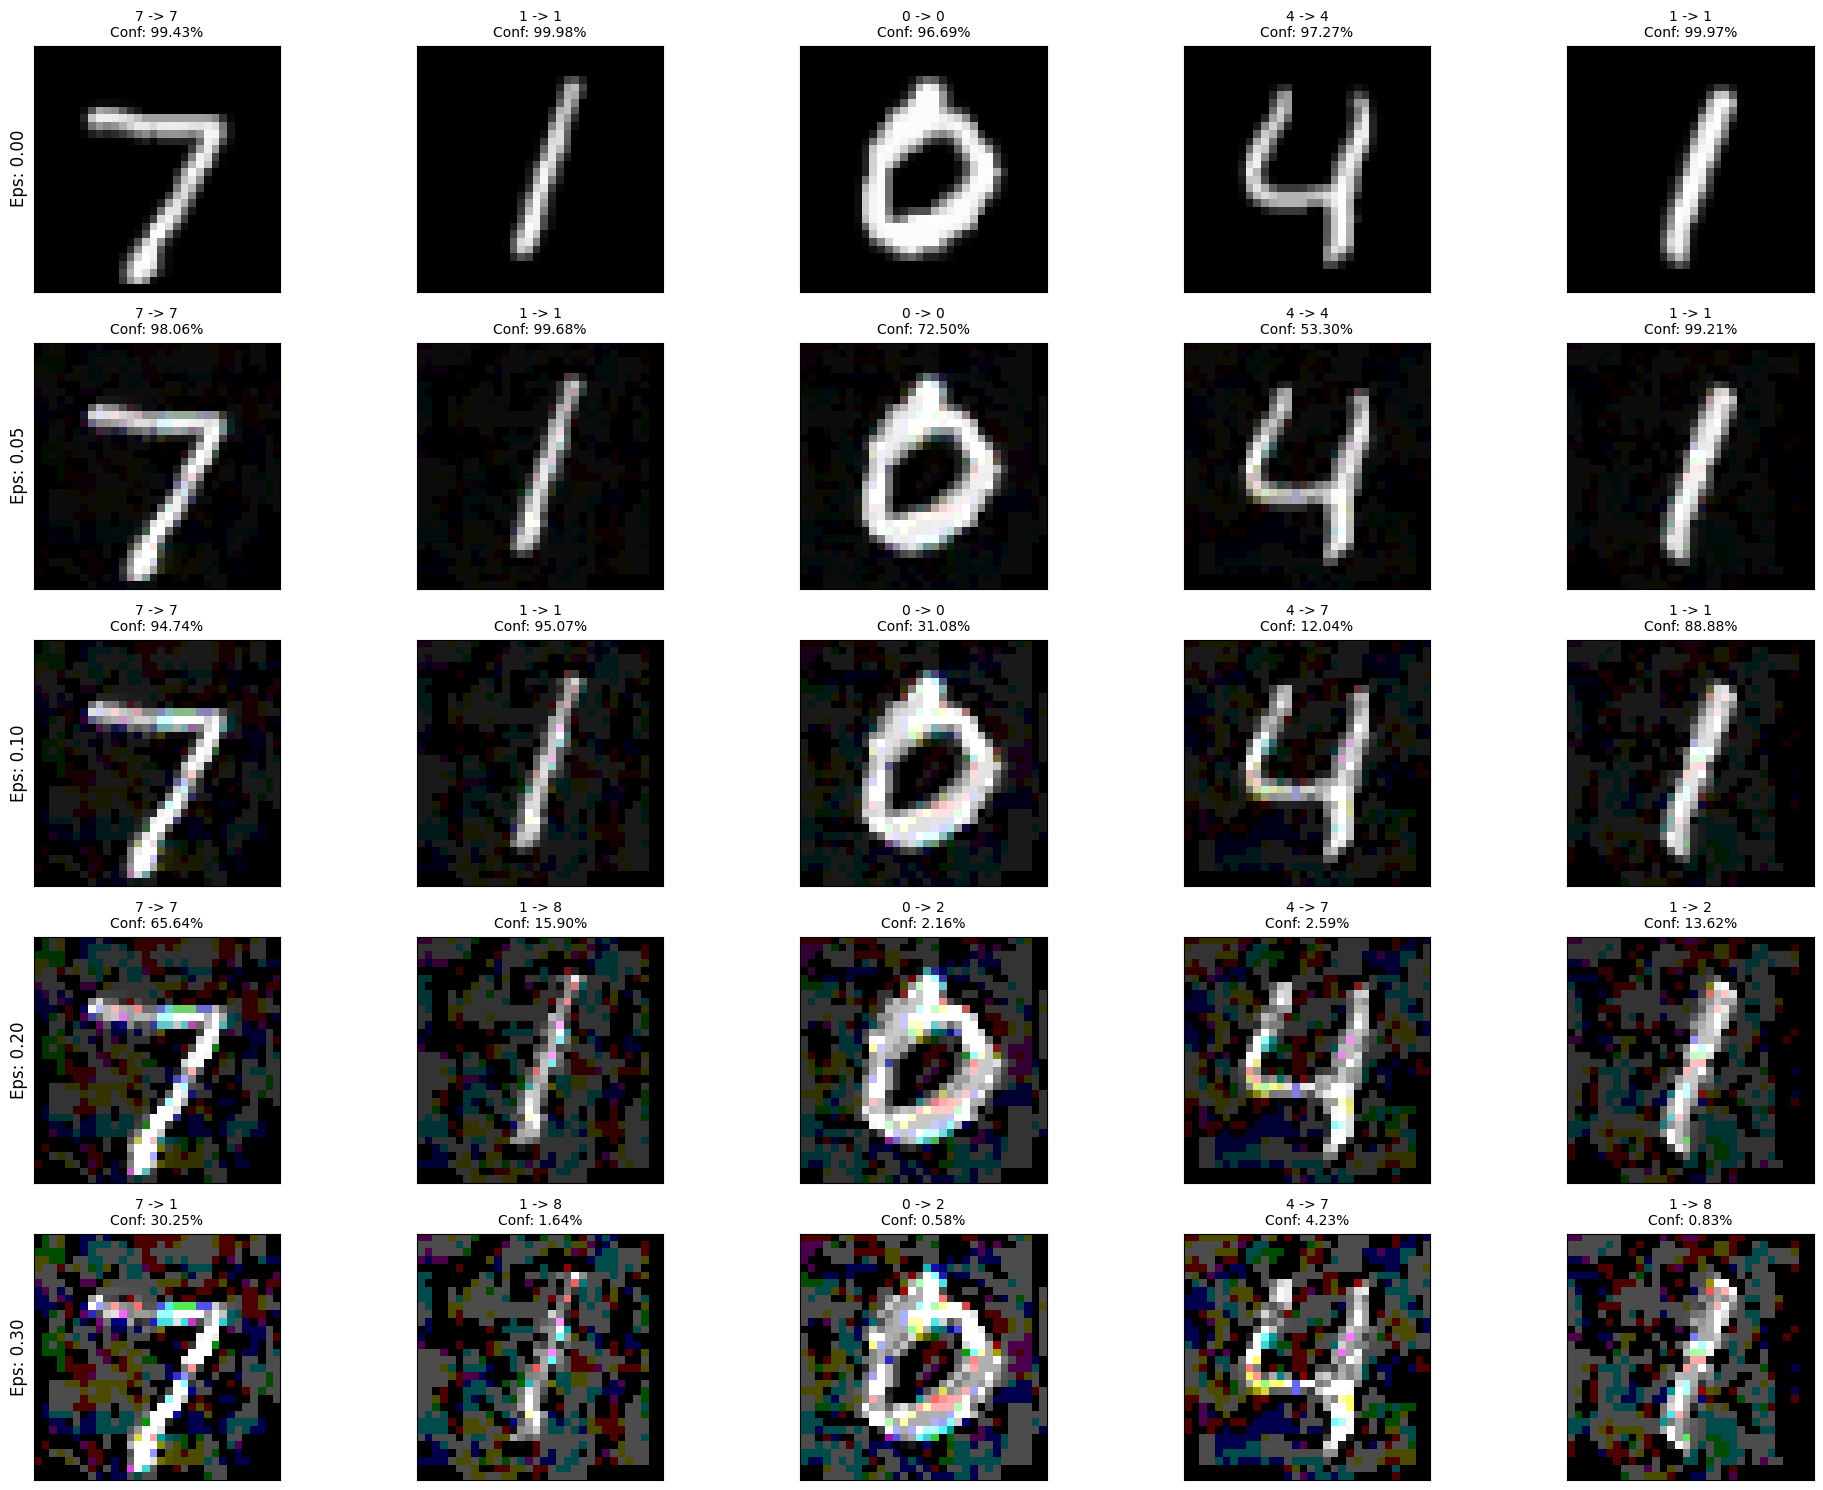

In [27]:
# Ergebnisse plotten und speichern
SAVE_DIR = "results/"
plot_and_save_adversarial_examples(results, epsilons, SAVE_DIR)



Die Visualisierung zeigt die Veränderungen der Eingabebilder durch FGSM-Angriffe:

- **Epsilon = 0.00**: Keine Störungen. Die Vorhersagen des Modells sind korrekt und die Konfidenz ist hoch.
- **Epsilon = 0.05**: Leichte Störungen. Einige Vorhersagen bleiben korrekt, aber die Konfidenz des Modells sinkt.
- **Epsilon = 0.10 bis 0.30**: Mit zunehmenden Störungen sinkt die Genauigkeit drastisch. Viele Vorhersagen sind falsch.



#### Modellgenauigkeit vs. Epsilon

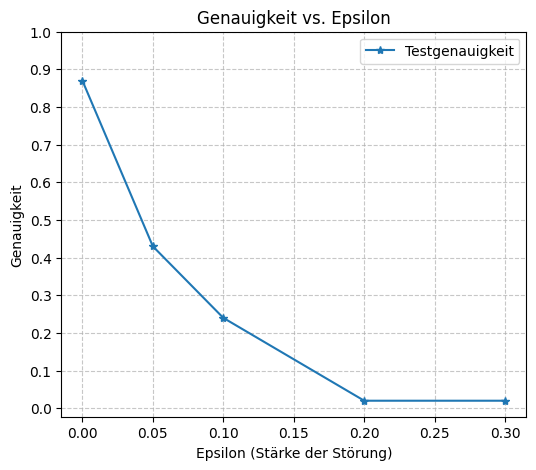

In [26]:
epsilons = [0, 0.05, 0.1, 0.2, 0.3]
plot_accuracy_vs_epsilon(results, epsilons, SAVE_DIR)

Der folgende Plot zeigt, wie die Modellgenauigkeit mit steigenden Werten von `epsilon` abnimmt:


- **Epsilon = 0.00**: Hohe Genauigkeit (~90%) ohne Störungen.
- **Epsilon = 0.05 bis 0.10**: Die Genauigkeit beginnt stark zu sinken (~30-50%).
- **Epsilon = 0.20 bis 0.30**: Fast keine korrekten Vorhersagen mehr (Genauigkeit ~0%).


Die Analyse zeigt, dass das Modell unter schwachen FGSM-Angriffen eine gewisse Robustheit aufweist, jedoch bei steigender Angriffs­stärke zunehmend anfällig wird. Insbesondere ab $ϵ = 0.1$ lässt sich ein signifikanter Rückgang der Klassifikationsgenauigkeit und der Konfidenz feststellen. 
Dies deutet darauf hin, dass das Modell gegen Adversarial Attacks gehärtet werden sollte.


## Fazit 

Adversariale Angriffe verdeutlichen die grundlegende Anfälligkeit moderner KI-Modelle gegenüber gezielten Manipulationen, insbesondere in sicherheitskritischen Anwendungsfeldern wie dem autonomen Fahren oder der medizinischen Bildverarbeitung. Die Analyse hat gezeigt, dass selbst minimal veränderte Eingabedaten zu erheblichen Fehlklassifikationen und einer deutlichen Reduktion der Modellkonfidenz führen können. Diese Schwachstellen gefährden nicht nur die Zuverlässigkeit von KI-Systemen in realen Szenarien, sondern untergraben auch das Vertrauen der Nutzer. 

Um diesen Herausforderungen zu begegnen, wurden verschiedene Abwehrstrategien untersucht. **Adversarial Training** [2] bietet eine robuste Grundlage, indem es adversarielle Beispiele in den Trainingsprozess integriert, zeigt jedoch Limitierungen hinsichtlich der Generalisierbarkeit auf unbekannte Angriffsarten. **Monitoring-Ansätze** [3] ermöglichen eine Echtzeit-Überprüfung eingehender Daten, sind jedoch bei neuartigen Angriffsmustern oft ineffektiv. **Defensive Distillation** [4] hingegen erhöht die Widerstandsfähigkeit von Modellen durch probabilistische Transformationen, bleibt jedoch in ihrer Effektivität gegen komplexe Angriffsszenarien begrenzt.

Die Ergebnisse unterstreichen, dass kein einzelner Ansatz eine umfassende Lösung bietet. Vielmehr wird eine Kombination aus verschiedenen Methoden, ergänzt durch kontinuierliche Forschung und Modellanpassungen, notwendig sein, um die Robustheit von KI-Systemen nachhaltig zu verbessern. Besonders in Bereichen, in denen Menschenleben oder kritische Infrastruktur betroffen sind, ist eine zuverlässige Absicherung unverzichtbar. Abschließend lässt sich festhalten, dass adversariale Robustheit nicht nur eine technische Herausforderung darstellt, sondern auch eine ethische und gesellschaftliche Verantwortung mit sich bringt, der sich die Forschung und Industrie gleichermaßen stellen müssen.

---

<small>
### Referenzen

[2] Ian J. Goodfellow et al., "Explaining and Harnessing Adversarial Examples", [https://arxiv.org/abs/1412.6572](https://arxiv.org/abs/1412.6572)  
[3] Federico Nesti et al., "Detecting Adversarial Examples by Input Transformations", [https://arxiv.org/pdf/2101.11466](https://arxiv.org/pdf/2101.11466)  
[4] Nicolas Papernot et al., "Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks", [https://arxiv.org/abs/1511.04508](https://arxiv.org/abs/1511.04508)  
</small>
